In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
import bisect

In [2]:
plt.style.use('ggplot')
sns.set_palette("viridis")
plt.rcParams.update({'font.size': 12})


In [14]:
def extract_disease_data(evaluation_data, epsilon):
    diseases = []
    
    for key, value in evaluation_data.items():
        if isinstance(key, str) and key.startswith('["symptoms", "') and not key.endswith('", "success"]') and '*' not in key:
            disease_name = key.split('", "')[1].split('"]')[0]
            total_count = value
            
            success_key = f'["symptoms", "{disease_name}", {epsilon}, "success"]'
            success_count = evaluation_data.get(success_key, 0)
            
            success_rate = success_count / total_count if total_count > 0 else 0
            
            diseases.append({
                "disease": disease_name,
                "total_count": total_count,
                "success_count": success_count,
                "success_rate": success_rate,
                "epsilon": epsilon
            })
    
    return pd.DataFrame(diseases)


epsilon_values = [0.5, 1.0, 2.0, 5.0, 10.0]
results_data = {}
all_disease_data = []

for eps in epsilon_values:
    with open(f'results/evaluation_eps_{eps}.json', 'r') as f:
        results_data[eps] = json.load(f)
    
    df_eps = extract_disease_data(results_data[eps], eps)
    all_disease_data.append(df_eps)

# combine
df_all_diseases = pd.concat(all_disease_data)

In [15]:
df_all_diseases.head()

,disease,total_count,success_count,success_rate,epsilon
0,Zonkitis,2,2,1.0,0.5
1,"Zonkitis"", 0.5, ""success",2,0,0.0,0.5
2,Snurflotron,1,1,1.0,0.5
3,"Snurflotron"", 0.5, ""success",1,0,0.0,0.5
4,Snurflesickness,2,2,1.0,0.5


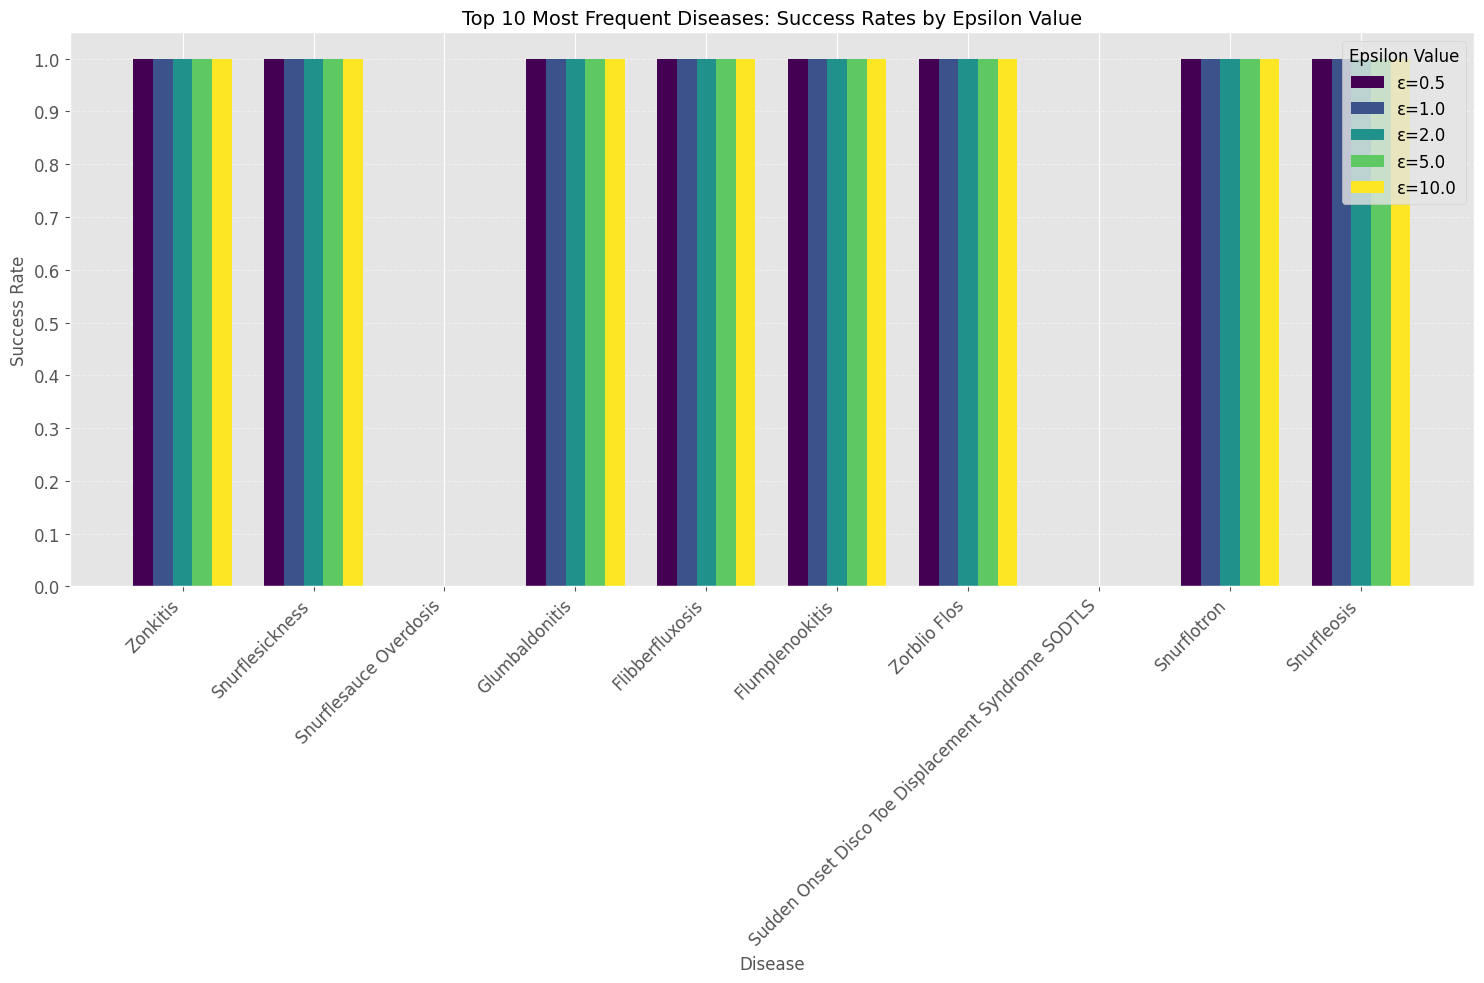

In [17]:
# top N most frequent dieases across all epsilons

N = 10  
disease_counts = df_all_diseases.groupby('disease')['total_count'].sum().reset_index()
top_diseases = disease_counts.sort_values('total_count', ascending=False).head(N)['disease'].tolist()

df_top = df_all_diseases[df_all_diseases['disease'].isin(top_diseases)]

plt.figure(figsize=(15, 10))

bar_width = 0.15
x = np.arange(len(top_diseases))
colors = plt.cm.viridis(np.linspace(0, 1, len(epsilon_values)))

for i, eps in enumerate(epsilon_values):
    df_eps = df_top[df_top['epsilon'] == eps]
    eps_data = {row['disease']: row for _, row in df_eps.iterrows()}
    success_rates = [eps_data.get(disease, {'success_rate': 0})['success_rate'] 
                     for disease in top_diseases]
    
    # plot
    plt.bar(x + (i - 2) * bar_width, success_rates, 
            width=bar_width, label=f'ε={eps}', color=colors[i])

plt.xlabel('Disease', fontsize=12)
plt.ylabel('Success Rate', fontsize=12)
plt.title(f'Top {N} Most Frequent Diseases: Success Rates by Epsilon Value', fontsize=14)
plt.xticks(x, top_diseases, rotation=45, ha='right')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.legend(title='Epsilon Value')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

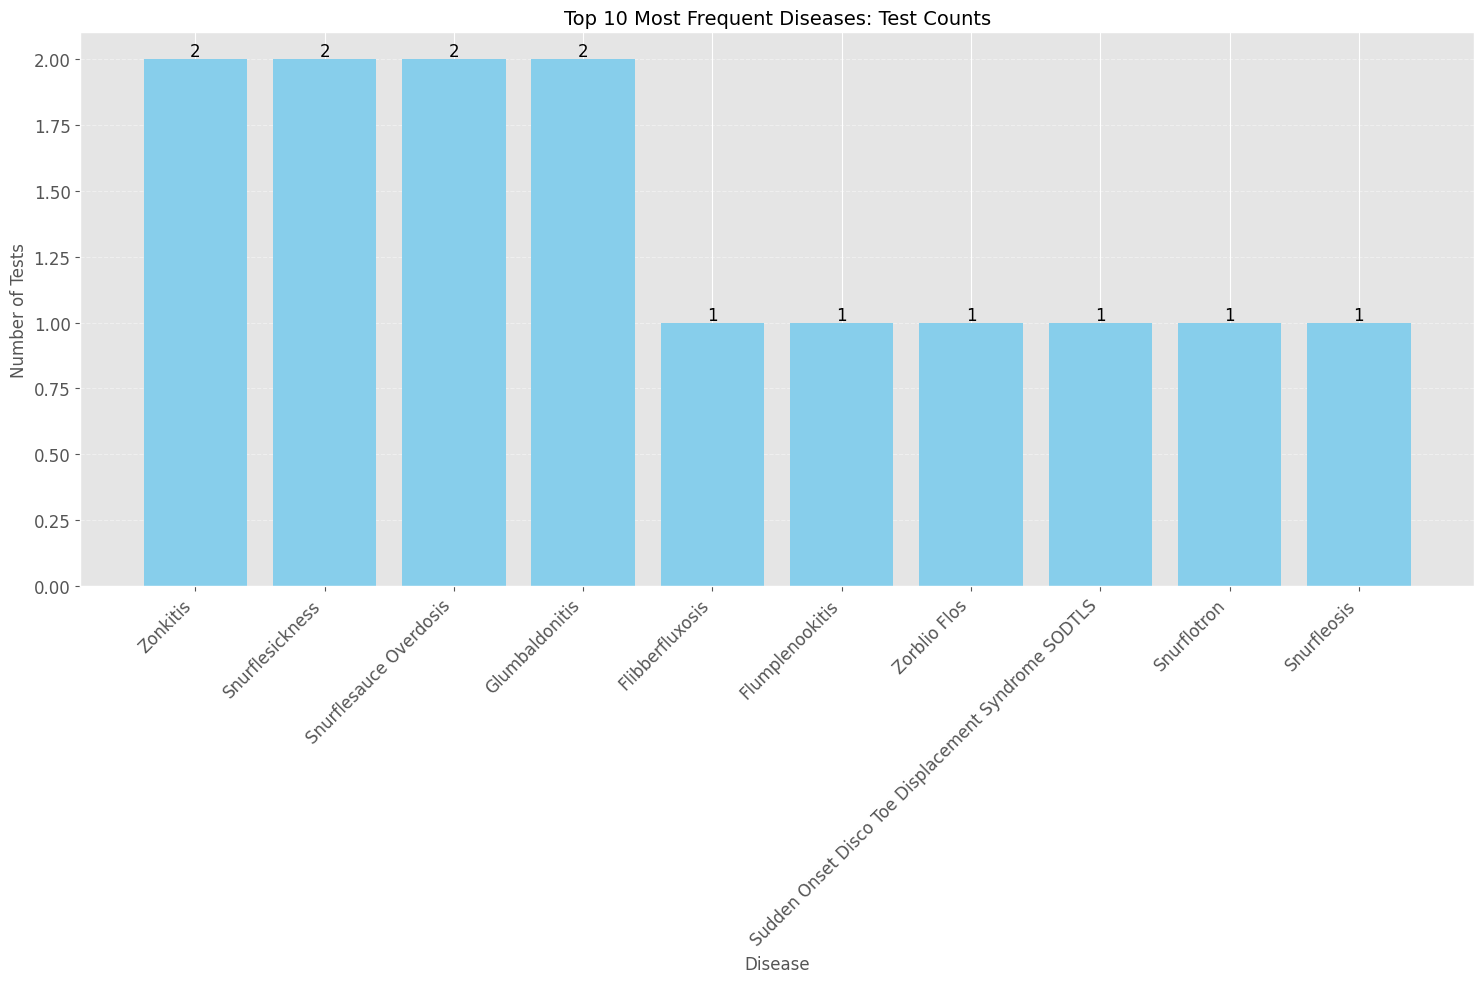

In [26]:
# number of tests
plt.figure(figsize=(15, 10))

eps = epsilon_values[0] # identical
df_eps = df_top[df_top['epsilon'] == eps]
test_counts = [df_eps[df_eps['disease'] == disease]['total_count'].values[0] 
               if not df_eps[df_eps['disease'] == disease].empty else 0 
               for disease in top_diseases]

plt.bar(x, test_counts, color='skyblue')

for i, count in enumerate(test_counts):
    plt.text(i, count+0.01, str(count), ha='center')

plt.xlabel('Disease', fontsize=12)
plt.ylabel('Number of Tests', fontsize=12)
plt.title(f'Top {N} Most Frequent Diseases: Test Counts', fontsize=14)
plt.xticks(x, top_diseases, rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

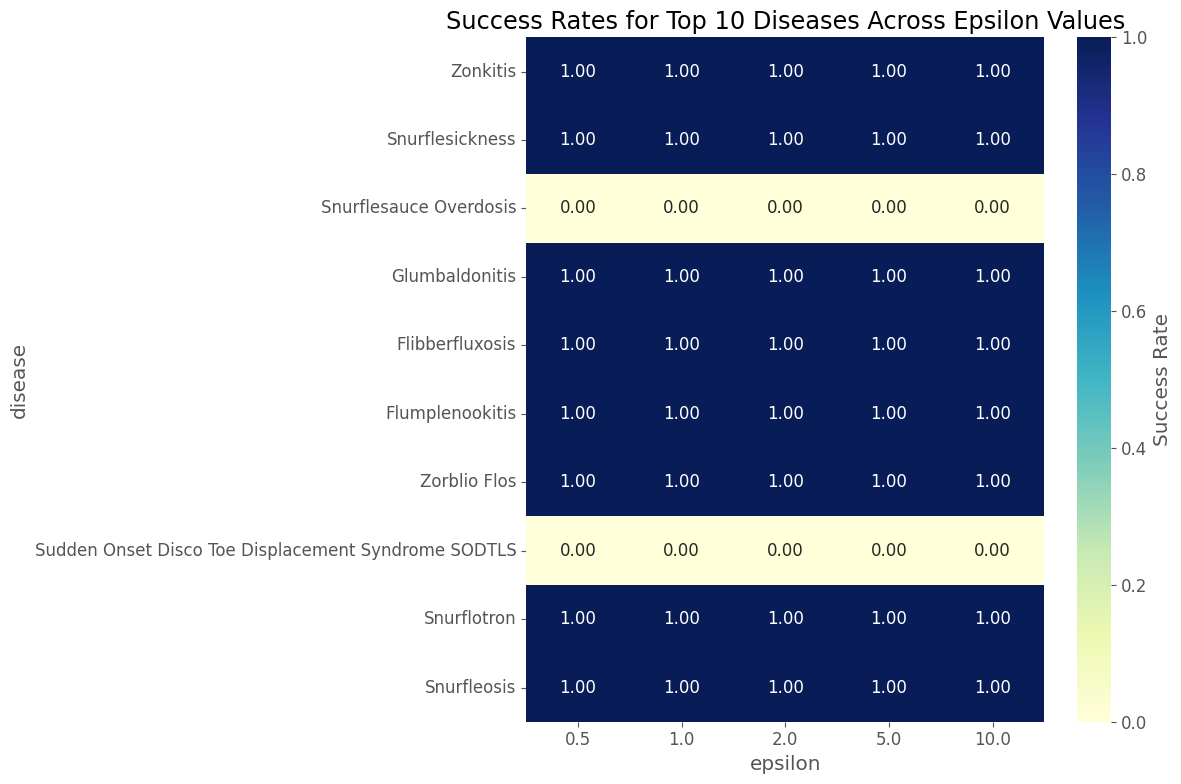

In [27]:
# heatmap: success rate by disease and epsilon
plt.figure(figsize=(12, max(8, len(top_diseases) * 0.4)))
import seaborn as sns

heatmap_data = df_top.pivot_table(
    index='disease', 
    columns='epsilon', 
    values='success_rate',
    aggfunc='first'
)
heatmap_data = heatmap_data.reindex(top_diseases)

# plot
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt=".2f", 
           vmin=0, vmax=1, cbar_kws={'label': 'Success Rate'})
plt.title(f'Success Rates for Top {N} Diseases Across Epsilon Values')
plt.tight_layout()
plt.show()

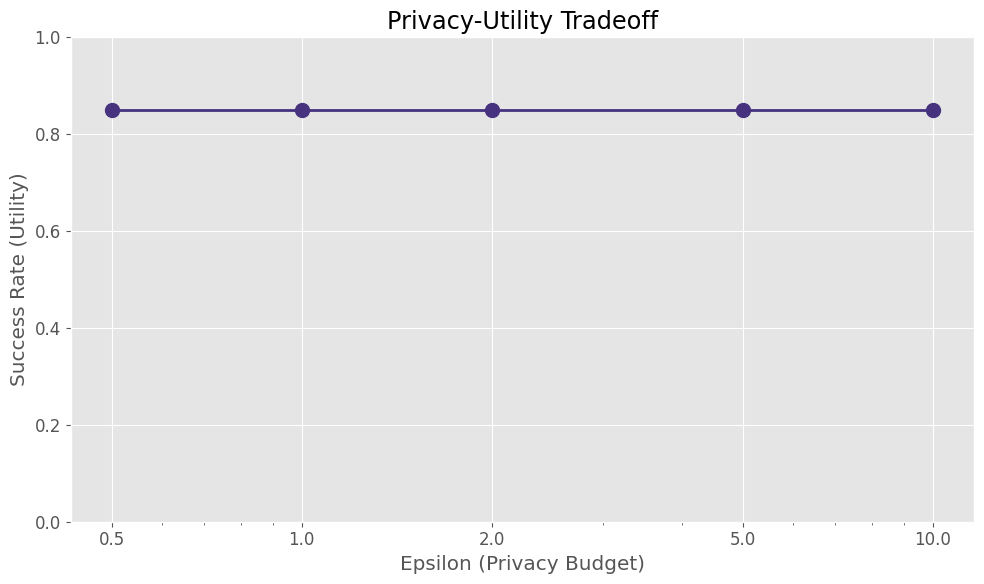

In [31]:
# adapted from my code in visualization.ipynb
import json
import matplotlib.pyplot as plt
import pandas as pd

epsilon_values = [0.5, 1.0, 2.0, 5.0, 10.0]
results = {}
   
for eps in epsilon_values:
    file_path = f'results/evaluation_eps_{eps}.json'
    try:
        with open(file_path, 'r') as f:
            results[eps] = json.load(f)
    except FileNotFoundError:
        print(f"No data file found for epsilon={eps}")
   
privacy_utility = []
for eps, data in results.items():
    total = data.get('["symptoms", "*"]', 0)
    success_key = f'["symptoms", "*", {eps}, "success"]'
    success = data.get(success_key, 0)
    success_rate = success / total if total > 0 else 0
       
    privacy_utility.append({
        "epsilon": eps,
        "privacy_level": 1/eps,  
        "success_rate": success_rate,
        "total_tests": total,
        "successful_tests": success
    })
   
df_privacy_utility = pd.DataFrame(privacy_utility)

df_privacy_utility = df_privacy_utility.sort_values('epsilon')
   
# plot
plt.figure(figsize=(10, 6))
plt.plot(df_privacy_utility['epsilon'], df_privacy_utility['success_rate'], 
        'o-', linewidth=2, markersize=10)
plt.title('Privacy-Utility Tradeoff')
plt.xlabel('Epsilon (Privacy Budget)')
plt.ylabel('Success Rate (Utility)')
plt.xscale('log')  # log scale for eps
plt.grid(True)
plt.xticks(epsilon_values, [str(eps) for eps in epsilon_values]) 
plt.ylim(0, 1)  
plt.tight_layout()
plt.show()